# LegacyHalos Surface Brightness Profiles

This notebook demonstrates--using a handful of galaxies as examples--how we measure and model the surface brightness profiles of the central galaxies in our sample.  

We use Michele Cappellari's [mge_fit_sectors](http://purl.org/cappellari/software) software to measure the azimuthally averaged surface-brightness profiles and fit various parameteric models to the data to determine the sizes and integrated fluxes of the galaxies in our sample.

We fit the complete sample using the script legacyhalos.legacyhalos_sbprofiles and generate QAplots from the output using legacyhalos.qaplots_legacyhalos_sbprofiles.

### Installing mge_fit_sectors

To install mge_fit_sectors we downloaded the [2017-07-08 tarball] (give the link!), unpacked its contents to a new **/path/to/mge_2017_07_28/mge** directory and added the top-level directory to our PYTHONPATH:

```python
export PYTHONPATH=/path/to/mge_2017_07_28:$PYTHONPATH
```
We also had to change line 274 in **mge_fit_sectors** to
```python
  from mge.cap_mpfit import mpfit
```
in order for the minimization algorithm to be imported successfully.

### Imports, paths, and other preliminaries.

In [1]:
import os 
import numpy as np

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

In [12]:
import legacyhalos.io
from legacyhalos.ellipse import mgefit_multiband

In [3]:
from mge.find_galaxy import find_galaxy
from mge.sectors_photometry import sectors_photometry
from mge.mge_fit_sectors import mge_fit_sectors as fit_sectors
from mge.mge_print_contours import mge_print_contours as print_contours

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [14]:
pixscale = 0.262 # [arcsec/pix] - assume DECam
band = ('g', 'r', 'z')
refband = 'r'

### Read the sample

In [6]:
def read_sample():
    cols = ('ra', 'dec', 'bx', 'by', 'brickname', 'objid', 'type',
            'shapeexp_r', 'shapeexp_e1', 'shapeexp_e2',
            'shapedev_r', 'shapedev_e1', 'shapedev_e2')
    sample = legacyhalos.io.read_catalog(extname='LSPHOT', upenn=True, columns=cols)
        
    rm = legacyhalos.io.read_catalog(extname='REDMAPPER', upenn=True,
                                     columns=('mem_match_id', 'z', 'r_lambda'))
    sample.add_columns_from(rm)

    sample = sample[40]
    print('Read {} galaxies.'.format(len(sample)))
    return sample

In [7]:
sample = read_sample()

Read 1 galaxies.


In [8]:
objid, objdir = legacyhalos.io.get_objid(sample)

### Reproduce ellipse fitting in legacyhalos.ellipse

In [11]:
data = legacyhalos.io.read_multiband(objid, objdir, band=band)
data.keys()

dict_keys(['g', 'g_mask', 'g_masked', 'r', 'r_mask', 'r_masked', 'z', 'z_mask', 'z_masked'])

#### Find the galaxy and get basic shape parameters.

 Pixels used: 2986
 Peak Img[j, k]: 89 89
 Mean (j, k): 91.21 92.87
 Theta (deg): 149.0
 Astro PA (deg): 121.0
 Eps: 0.310
 Major axis (pix): 39.0


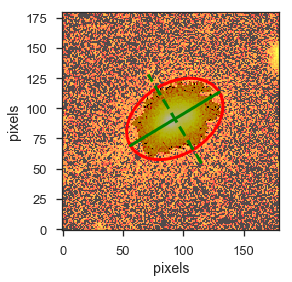

In [15]:
galaxy = find_galaxy(data[refband], nblob=1, plot=True)

In [ ]:
geometry = EllipseGeometry(x0=galaxy.xmed, y0=galaxy.ymed,
                           sma=0.5*mgefit[refband].majoraxis, eps=mgefit[refband].eps,
                           pa=np.radians(-mgefit[refband].theta))


In [10]:
stop

NameError: name 'stop' is not defined

### Reproduce MGE fitting in legacyhalos.ellipse

In [ ]:
gal = parent[0]

In [ ]:
suffix = '{0:05d}'.format(gal['OBJID'])
imfile = os.path.join(coaddsdir, suffix, '{}-image-r.fits.fz'.format(suffix))
modelfile = os.path.join(coaddsdir, suffix, '{}-model-r.fits.fz'.format(suffix))
img, hdr = fits.getdata(imfile, ext=0, header=True)
model = fits.getdata(modelfile, ext=0)

In [ ]:
residimg = img - model

In [ ]:
ff = find_galaxy(residimg, plot=True)

In [ ]:
ss = sectors_photometry(residimg, ff.eps, ff.theta, ff.xpeak, ff.ypeak, badpixels=None,
                           n_sectors=19, mask=None, minlevel=0, plot=True)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.log10(ss.radius*pixscale), 22.5-2.5*np.log10(ss.counts), s=10)
ax.set_ylim(32, 22)

In [ ]:
pp = fit_sectors(ss.radius, ss.angle, ss.counts, ff.eps,
                 ngauss=12, negative=False, sigmaPSF=0, normPSF=1, scale=pixscale,
                 rbounds=None, qbounds=None, linear=False, quiet=False,
                 outer_slope=4, bulge_disk=False, sol=0, plot=True)

In [ ]:
_ = print_contours(residimg, ff.pa, ff.xpeak, ff.ypeak, pp.sol, 
                   binning=2, normpsf=1, magrange=6, mask=None, 
                   scale=pixscale, sigmapsf=0)